In [1]:
#HIGH RESOLUTION SPECTROSCOPIC DATA REDUCTION PIPELINE FOR SPATIALLY RESOLVED OBJECTS

import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import reduction_utils as ru #import reduction functions
#import cosmics #import cosmic ray utility
from scipy.ndimage import zoom

%matplotlib inline 

In [2]:
#Set Paths
MainDirectory = '/Users/ryleighfitzpatrick/Desktop/Research/Titan/KeckObs/Keck2017/' #Outermost reduction directory
data_path = MainDirectory+'rawData/SPEC' #Data found here
save_path = MainDirectory+'reducedData/NIRSPEC-5-AO/Titan_HR_Offset_3/order49/Pair_1/pyRed' #Save reduction files here

#Choose Data image(s) for use in reduction
sciImgName = 'jul10s0086'
arcImgName = 'jul10s0065'
flatImgNames = ['jul10s0060','jul10s0061','jul10s0062','jul10s0063','jul10s0064']

In [3]:
os.chdir(data_path) #Change to data directory

In [4]:
reload(ru)

<module 'reduction_utils' from '/Users/ryleighfitzpatrick/MyPrograms/reduction_utils.pyc'>

In [5]:
%%capture 
#Ignore (pointless) astropy.io.fits warning
ru.cosmicRayCleanup(sciImgName+'.fits', sciImgName+'_cleaned.fits')
ru.cosmicRayCleanup(arcImgName+'.fits', arcImgName+'_cleaned.fits')
for flatImg in flatImgNames:
    ru.cosmicRayCleanup(flatImg+'.fits', flatImg+'_cleaned.fits')

#Read in data image(s) and header(s)
rawSpec, dataHeader = ru.readFits(sciImgName+'_cleaned.fits', head='yes')
arcImg = ru.readFits(arcImgName+'_cleaned.fits', head='no')

#Create Median Combined Flat from all flat field images
#Read in data to list of 2D arrays (each 2D array is a flat) 
flats = [ru.readFits(f+'_cleaned.fits', head='no') for f in flatImgNames] 
flats = np.dstack(flats) #Stack Flat Images in 3D array
flatHR = np.median(flats, axis=2)#Median Combine flat images along 3rd axis (match pixels for each image)


#Look at later for reading in list of flat & bias' files
#filenames = ['file1.fits', 'file2.fits']
#imgs = [ru.readFits(fname,head='yes') for fname in filenames]

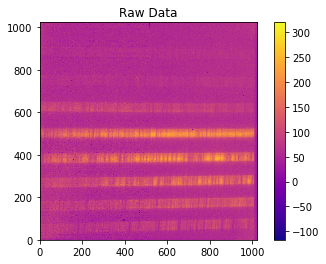

In [6]:
#plot raw data image
ru.plotFitsImage(rawSpec, title = 'Raw Data', vmin = rawSpec.min(), vmax =rawSpec.max())

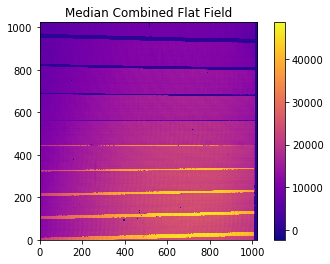

In [170]:
ru.plotFitsImage(flatHR, title='Median Combined Flat Field', vmin=flatHR.min(), vmax=flatHR.max())

# Separate Data By Order

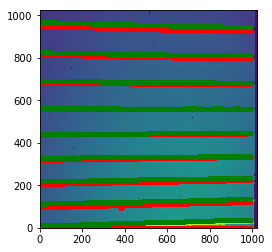

In [171]:
orderSeparation, orderStartEnd = ru.findOrderSeparationFromFlatByVertCut(flatHR, 10, 1005, plot='yes')

In [172]:
orders = [52, 51, 50, 49, 48, 47, 46, 45]

flatByOrders = ru.splitImageByOrder(flatHR, orders, orderStartEnd)
specByOrders = ru.splitImageByOrder(rawSpec, orders, orderStartEnd)

spatRecFlat = ru.performSpatialRectification(flatByOrders, orders)  
spatRecImg = ru.performSpatialRectification(specByOrders, orders)  

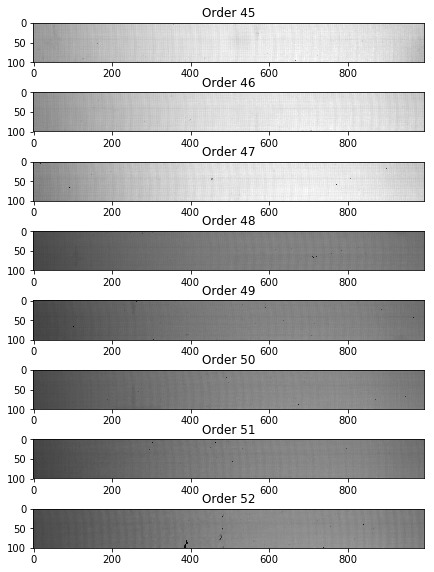

In [173]:
fig, ax = plt.subplots(8, figsize=(7,10))

for i in range(8):
    ax[i].imshow(spatRecFlat[45+i], cmap='gray', vmin = spatRecFlat[45+i].min(), vmax = spatRecFlat[45+i].max())
    ax[i].title.set_text('Order '+str(45+i))

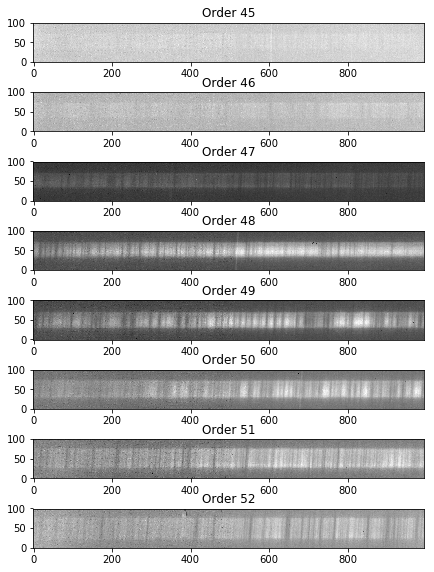

In [191]:
fig, ax = plt.subplots(8, figsize=(7,10))

for i in range(8):
    ax[i].imshow(spatRecImg[45+i], cmap='gray', origin='lower')
    ax[i].title.set_text('Order '+str(45+i))


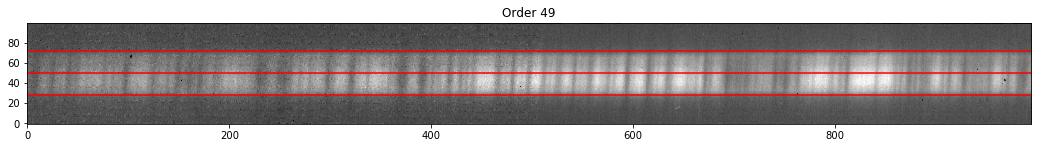

In [1966]:
fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(spatRecImg[49], cmap='gray', origin='lower')
ax.title.set_text('Order 49')

ax.axhline(y = 28, color = 'r')
ax.axhline(y = 50, color = 'r')
ax.axhline(y = 72, color = 'r')

# Spectral Rectification with Model Spectra

In [1942]:
os.chdir(MainDirectory+'KECKspectra/')

modelSpec = np.loadtxt('ModelSpec_60')

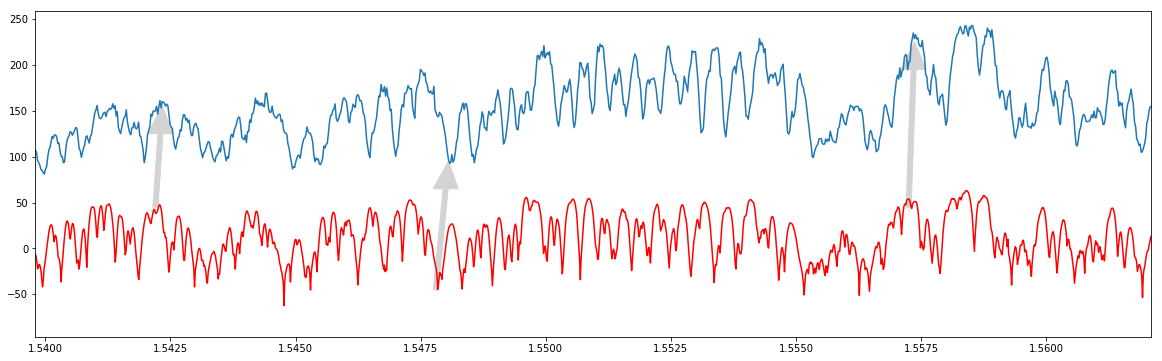

In [1939]:
#Plot data(blue) and model(red)
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(np.linspace(1.5398, 1.5621, 995, endpoint=True), np.median(spatRecImg[49][40:50], 0))
ax.plot(modelSpec[:,0], (modelSpec[:,2]*1000) - 80, color='r')
ax.set_xlim(1.5398,1.5621)

ax.arrow(1.5478, -45, 0.0002, 110, width=0.0001, head_width=0.0005, head_length=30, color='lightgray')
ax.arrow(1.55725, 45, 0.0001, 150, width=0.0001, head_width=0.0005, head_length=30, color='lightgray')
ax.arrow(1.5422, 45, 0.0001, 80, width=0.0001, head_width=0.0005, head_length=30, color='lightgray')

#ax.axvline(x=1.54012)
#ax.axvline(x=1.5422)
#ax.axvline(x=1.54477)
#ax.axvline(x=1.5478)
#ax.axvline(x=1.55318)
#ax.axvline(x=1.55725)
#ax.axvline(x=1.55993)
#ax.axvline(x=1.56192)

In [1944]:
modelSpec = np.column_stack((modelSpec[:,0], modelSpec[:,2]))
print modelSpec

[[ 1.70068027  0.0266679 ]
 [ 1.70066292  0.02307822]
 [ 1.70064557  0.00920119]
 ..., 
 [ 1.45015807  0.0450716 ]
 [ 1.45014545  0.04219518]
 [ 1.45013284  0.03997879]]


In [2093]:
print spatRecImg[49]

[[ 74.          77.          62.         ...,  68.          66.          65.        ]
 [ 71.          67.          65.77777778 ...,  69.64646465  69.49494949
   74.64646465]
 [ 59.          67.          58.44444444 ...,  64.51515152  60.2020202
   67.5959596 ]
 ..., 
 [ 70.11111111  70.77777778  67.22222222 ...,  61.60606061  60.41414141
   68.29292929]
 [ 86.55555556  67.88888889  70.11111111 ...,  66.6969697   74.19191919
   69.94949495]
 [ 74.          72.          63.         ...,   0.           0.           0.        ]]


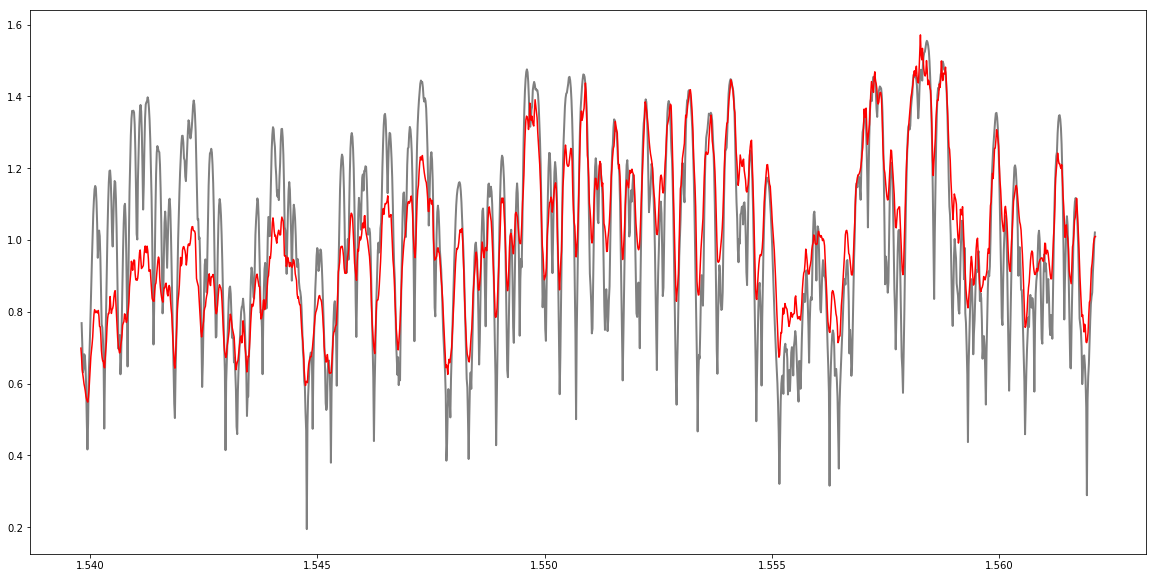

In [2094]:
#Order 49
titanSpec_N_O49, modelSpec_O49 = ru.peformSpecRecByOrderAndVertMedComb(spatRecImg, 
                                                        modelSpec, 49, [1.5398, 1.5621], [28, 50], plot = 'yes')

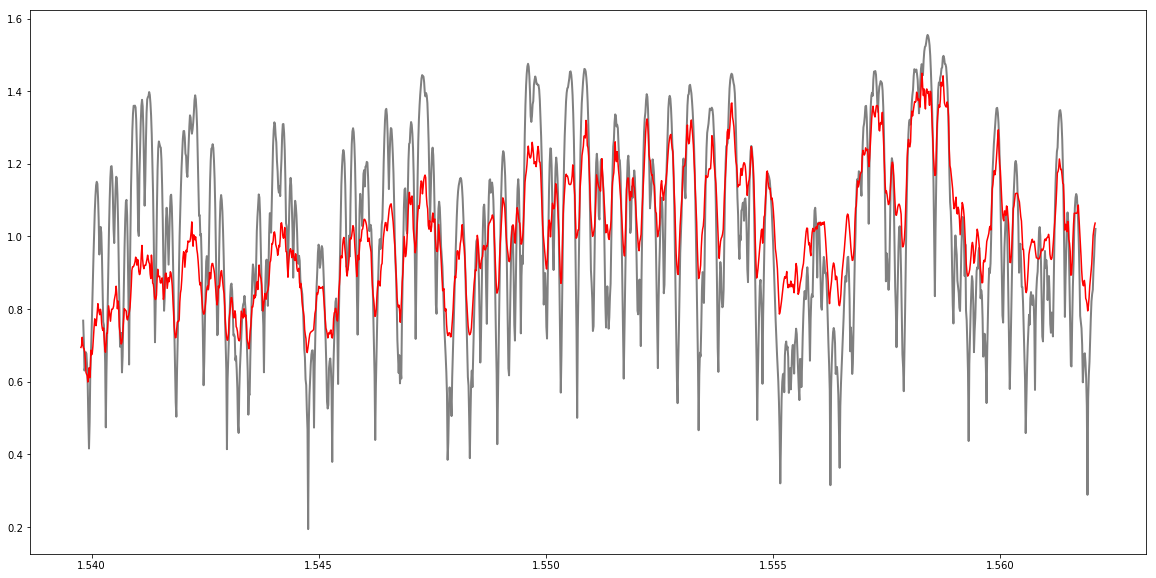

In [1970]:
#Order 49
titanSpec_S_O49, modelSpec_O49 = ru.peformSpecRecByOrderAndVertMedComb(
                                        spatRecImg, modelSpec, 49, [1.5398, 1.5621], [50, 72], plot = 'yes')

In [1982]:
import matplotlib.image as mpimg
os.chdir(MainDirectory)
titanNASA = mpimg.imread('Titan_jpg_NASA.jpg')


#We positioned the slit N-S and then
recorded 600 min observations 
starting 0.1554 arcsec to the east
of center, and stepping 0.041 (the 
slit width) west 7 times to cover
a contigous region 0.287 arc secs. 
As Titan is 0.777 arc secs in diameter, 
this is a swath covering 37% of the
disk.  

In [2044]:
#Circle radius is 420 pixels- diameter is 840 pixels
#Titan is 0.777 arcsec in diameter
#Slit width is 0.041 arcsec, length is 2.26 arcsec

imgDiameter = 840.0
imgCenter = (520., 480.)

slitWidth = ((0.041/0.777) * imgDiameter)
slitLength = ((2.26/0.777) * imgDiameter)

lowerX = []

lowerX.append(imgCenter[0] - slitWidth/4.)
lowerY = imgCenter[1] - slitLength/4.

#Start 0.1554 arcsec east of center
lowerX.append(imgCenter[0] + imgDiameter*(0.1554/0.777))

#Shift over by 0.041 arcsec west 7 times
for i in range(1,7):
    lowerX.append(lowerX[i] - imgDiameter*(0.041/0.777))

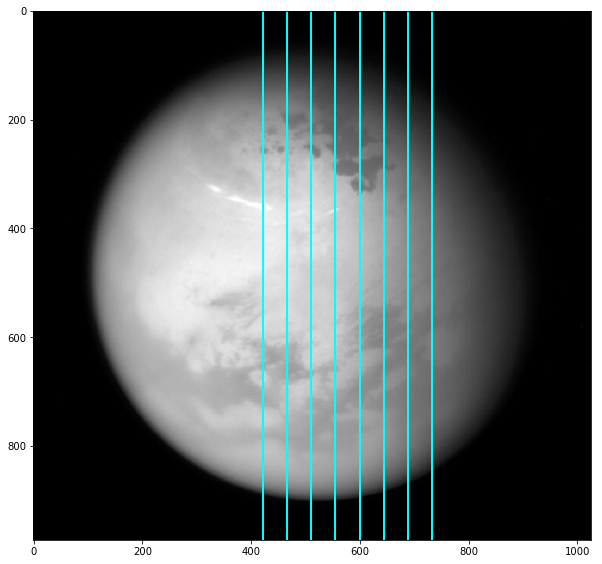

In [2058]:
import matplotlib.patches as patches
circle1 = plt.Circle((520, 480), 420, color='r', fill=False, lw = 5)
rect = patches.Rectangle((lowerX[0], lowerY), slitWidth/2., slitLength/2., lw=2,edgecolor='cyan',facecolor='none')
rect1 = patches.Rectangle((lowerX[1], lowerY), slitWidth/2., slitLength/2., lw=2,edgecolor='cyan',facecolor='none')

fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(titanNASA, cmap = "gray")
#ax.add_artist(circle1)
for i in range(1,8):
    rect = patches.Rectangle((lowerX[i], lowerY), slitWidth, slitLength/2., 
                                                                 lw=2,edgecolor='cyan',facecolor='none')
    ax.add_artist(rect)

In [2080]:
index = np.where((titanSpec_N_O49[:,0] <= 1.556) & (titanSpec_N_O49[:,0] >= 1.55))
avgTitanN = np.average(titanSpec_N_O49[int(index[0][0]):int(index[0][-1]), 1])



In [2081]:
print avgTitanN

1.10455566261


(1.5686, 1.5945)

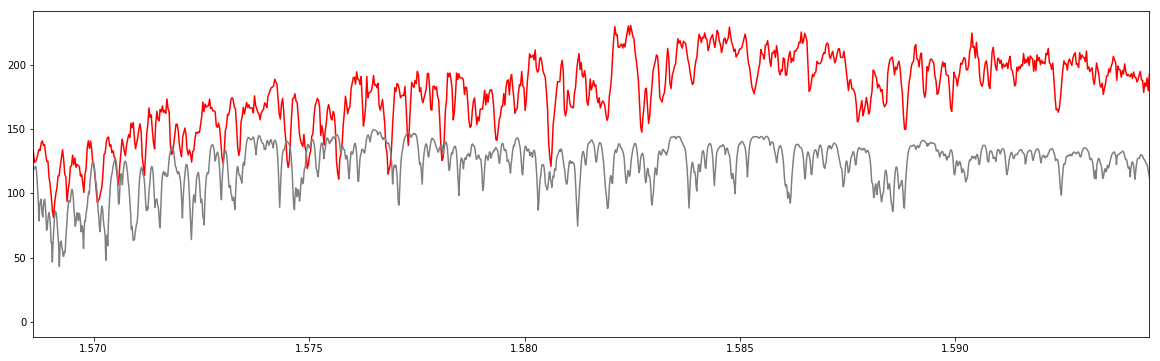

In [1925]:
#Plot data(blue) and model(red)
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(np.linspace(1.5686, 1.5945, 995, endpoint=True), np.median(spatRecImg[48][40:50], 0), color = 'r')
ax.plot(modelSpec[:,0], (modelSpec[:,2]*1000) , color='gray')
ax.set_xlim(1.5686, 1.5945)

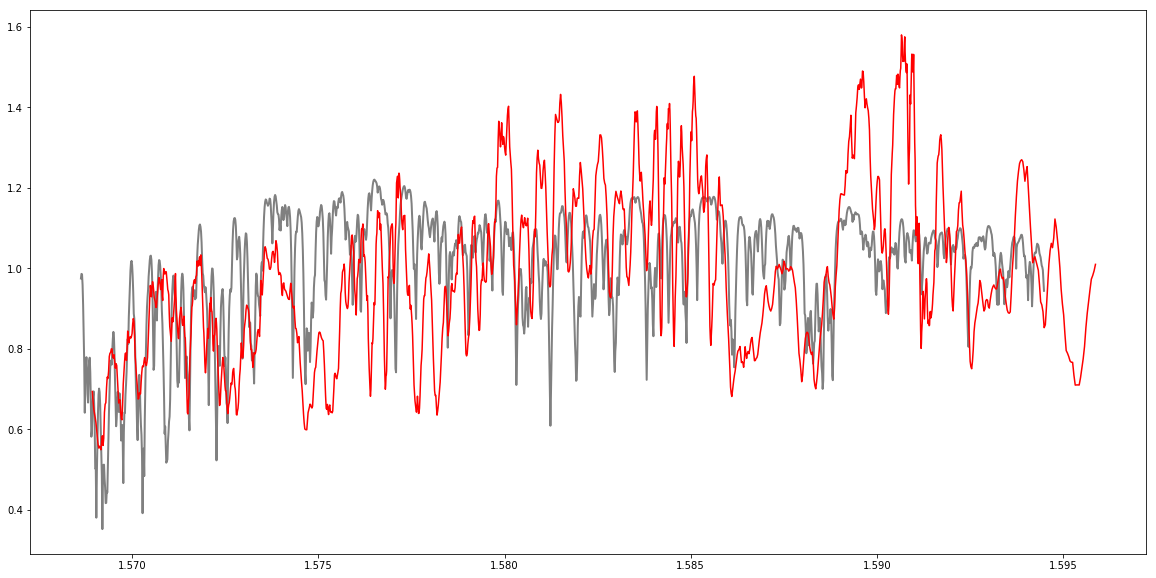

In [1924]:
ru.peformSpecRecByOrderAndVertMedComb(spatRecImg, modelSpec, 48, [1.5686, 1.59449], [40, 60], 
                                        numPoints = 15, plot = 'yes', indivPlot = 'no')
#plt.axvline(x = 1.5726)

#TO DO: Plot Earth's absorption spectrum in this region- is that why this is SO TERRIBLE?

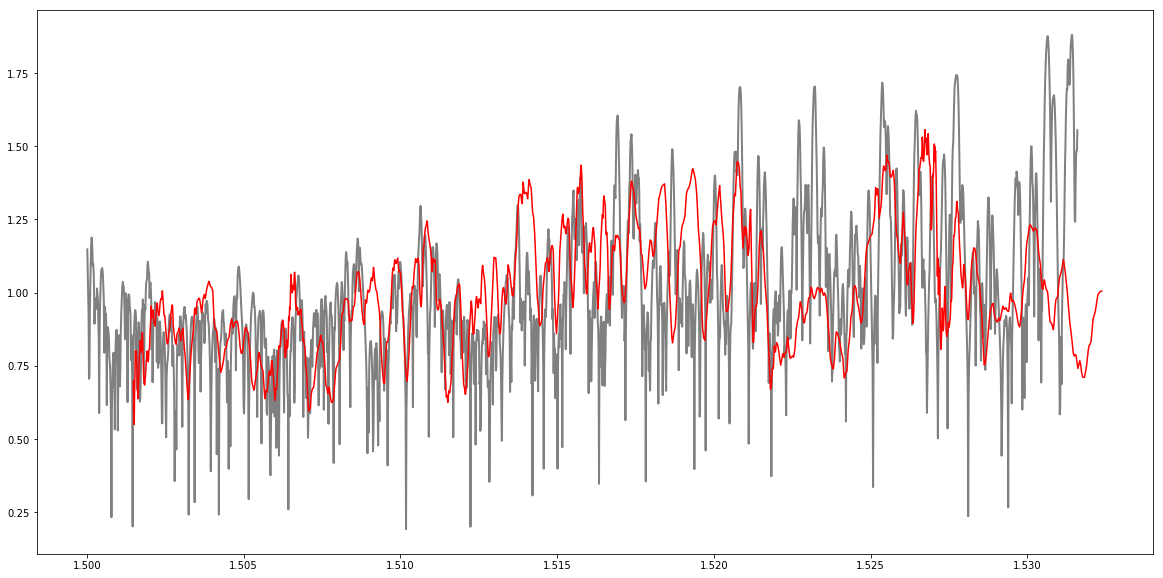

In [1866]:
#Order 50
ru.peformSpecRecByOrderAndVertMedComb(spatRecImg, modelSpec, 50, [1.50, 1.5316], [30, 50], numPoints = 15, 
                                      indivPlot = 'no', plot = 'yes')